In [31]:
import rockfish as rf
import rockfish.actions as ra
from rockfish.labs.dataset_properties import DatasetPropertyExtractor
from rockfish.labs.recommender import ModelType
from rockfish.labs.steps import ModelSelection, Recommender

import matplotlib.pyplot as plt
import pandas as pd
import pickle
import asyncio
import seaborn as sns
import os
from datetime import datetime
import pytz

In [2]:
 conn = rf.Connection.from_config()

#### Utils

In [11]:
def plot_bar(dataset, syn, plot_config):
    d = dataset.to_pandas()
    s = syn.to_pandas()

    x_col_name = ",".join(plot_config["x"])
    y_col_name = plot_config["y"]

    # get x from dataset and syn
    for df in [d, s]:
        for col in plot_config["x"]:
            df[col] = df[col].astype(str)
        df[x_col_name] = df[plot_config["x"]].agg(''.join, axis=1)

    # compare only those categories (top k = 7) that exist in real
    d = d.sort_values(by=y_col_name, ascending=False)
    d = d.loc[d[x_col_name].isin(d[x_col_name][:7])]
    s = s.loc[s[x_col_name].isin(d[x_col_name])]

    x_col = d[x_col_name].to_list()
    x_col.extend(s[x_col_name].to_list())

    # get y from dataset and syn
    y_col = d[plot_config["y"]].to_list()
    y_col.extend(s[plot_config["y"]].to_list())

    # create hue col
    hue_col = [f"{dataset.name()}"] * len(d) + [f"{syn.name()}"] * len(s)

    hue_col_name = "Dataset"
    df = pd.DataFrame({
        x_col_name: x_col,
        y_col_name: y_col,
        hue_col_name: hue_col
    })

    fig, ax = plt.subplots()
    fig.set_figwidth(plot_config["figwidth"])
    sns.barplot(df, x=x_col_name, y=y_col_name, hue=hue_col_name)
    fig.suptitle(plot_config["title"])
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.savefig(f"{plot_config['title']}.png", dpi=500)

def data_quality_check(dataset, syn, fidelity_requirements):
    plot_configs = [
        {"custom_plot": None, "x": ["fraud"], "y": "fraud_count", "title": "Distribution of transaction type", "figwidth": 5},
        {"custom_plot": None, "x": ["age", "gender"], "y": "amount_perc", "title": "Percentage of amount per customer age, gender", "figwidth": 10},
    ]
    for query, plot_config in zip(fidelity_requirements, plot_configs):
        print(f"Performing check for: {query}")
        d = dataset.sync_sql(query)
        s = syn.sync_sql(query)
        plot_bar(dataset=d, syn=s, plot_config=plot_config)


## Onboarding

In [3]:
sample_data = rf.Dataset.from_csv("Real", "transactions_2023-08-01_hour09.csv")

In [4]:
sample_data.to_pandas()

,customer,email,age,gender,merchant,category,amount,fraud,timestamp
0,C100045114,nmontgomery@example.net,4,M,M348934600,transportation,35.13,0,2023-08-01 09:12:51
1,C100045114,nmontgomery@example.net,4,M,M348934600,transportation,27.63,0,2023-08-01 09:19:27
2,C100045114,nmontgomery@example.net,4,M,M348934600,transportation,13.46,0,2023-08-01 09:26:04
3,C100045114,nmontgomery@example.net,4,M,M348934600,transportation,28.86,0,2023-08-01 09:32:40
4,C100045114,nmontgomery@example.net,4,M,M151143676,barsandrestaurants,64.99,0,2023-08-01 09:39:17
...,...,...,...,...,...,...,...,...,...
16793,C1638237205,elizabethdavis@example.com,3,M,M348934600,transportation,53.03,0,2023-08-01 09:38:07
16794,C1638237205,elizabethdavis@example.com,3,M,M348934600,transportation,21.82,0,2023-08-01 09:40:38
16795,C1638237205,elizabethdavis@example.com,3,M,M348934600,transportation,43.57,0,2023-08-01 09:43:09
16796,C1638237205,elizabethdavis@example.com,3,M,M348934600,transportation,20.14,0,2023-08-01 09:45:40


In [5]:
session_key="customer"
metadata_fields = ["age", "email", "gender"]
fidelity_requirements = [
    "SELECT fraud, COUNT(fraud) AS fraud_count FROM my_table GROUP BY fraud",
    "SELECT (SUM(amount) * 100)/SUM(SUM(amount)) OVER () as amount_perc, age, gender FROM my_table GROUP BY age, gender",
]
privacy_requirements = {"email": "mask"}

### Get Recommendations

In [6]:
dataset_properties = DatasetPropertyExtractor(
    dataset=sample_data,
    session_key=session_key,
    metadata_fields=metadata_fields
).extract()

recommender_output = Recommender(
    dataset_properties=dataset_properties,
    steps=[ModelSelection()]
).run()

print(recommender_output.report)

# _________________________________________________________________________
#
# RECOMMENDED CONFIGURATIONS
#
# (Remove or change any actions or configurations that are inappropriate
#  for your use case, or add missing ones)
# _________________________________________________________________________


We detected a timeseries dataset with the following properties:
Dimensions of dataset: (16798 x 9)
Metadata fields: ['age', 'email', 'gender']
Measurement fields: ['fraud', 'amount', 'merchant', 'category']
Timestamp field: timestamp
Session key field: customer
Number of sessions: 1250

# _________________________________________________________________________
#
# ~~~~~ Model recommendations ~~~~~
# _________________________________________________________________________


We recommend using the TimeGAN model.

For training, we recommend the following model parameters:
DGConfig(sample_len=1, activate_normalization_per_sample=True, generator_attribute_num_layers=5, generator_feature_num_

### Update Recommendations

In [7]:
train_action = recommender_output.actions[0]
train_action.config().doppelganger.batch_size = 512
train_action.config().doppelganger.epoch = 3
train_action.config().doppelganger.epoch_checkpoint_freq = 3
generate_action = recommender_output.actions[1]

In [8]:
remap_email_action = ra.Transform(
    {"function": {"remap": ["delimiter_mask", "email", {"delimiter":"@", "from_end": False}]}}
)

### Run Data Quality Checks

In [12]:
save = ra.DatasetSave(name="Rockfish")

builder = rf.WorkflowBuilder()
builder.add(sample_data)
builder.add(remap_email_action, parents=[sample_data])
builder.add(train_action, parents=[remap_email_action])
builder.add(generate_action, parents=[train_action])
builder.add(save, parents=[generate_action])

if not os.path.exists("transactions_2023-08-01_hour09_syn.csv"):
    workflow = await builder.start(conn)   
    async for log in workflow.logs():
        print(log)
    syn_data = await (await workflow.datasets().last()).to_local(conn)
else:
    syn_data = rf.Dataset.from_csv(name="Rockfish", path="transactions_2023-08-01_hour09_syn.csv")

Performing check for: SELECT fraud, COUNT(fraud) AS fraud_count FROM my_table GROUP BY fraud
Performing check for: SELECT (SUM(amount) * 100)/SUM(SUM(amount)) OVER () as amount_perc, age, gender FROM my_table GROUP BY age, gender


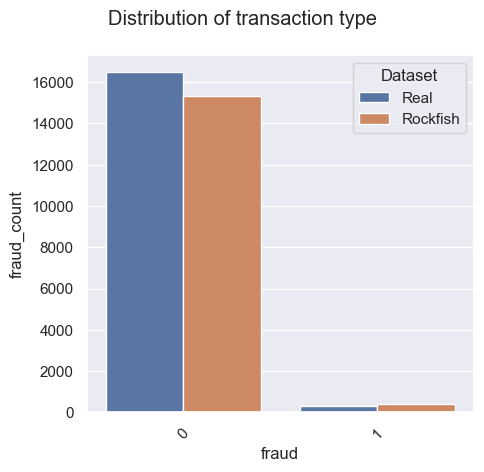

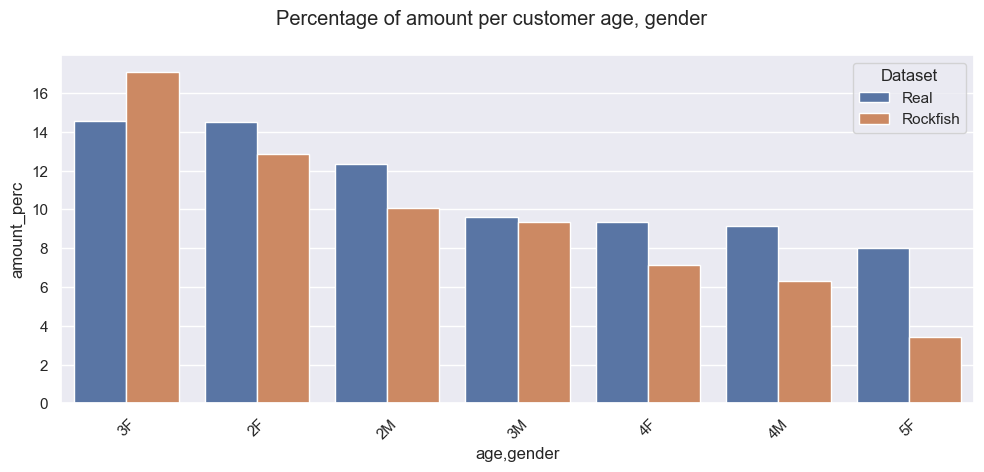

In [13]:
data_quality_check(sample_data, syn_data, fidelity_requirements)

## Train

In [14]:
datastream = ra.DatastreamLoad()

builder = rf.WorkflowBuilder()
builder.add(datastream)
builder.add(remap_email_action, parents=[datastream])
builder.add(train_action, parents=[remap_email_action])
runtime_workflow = await builder.start(conn)
runtime_workflow.id()

'40h9EoXIfa6j17ywbKgUfb'

In [15]:
dataset_names = [
    "transactions_2023-08-01_hour09",
    "transactions_2023-08-01_hour10",
    "transactions_2023-08-01_hour11"
]

In [16]:
try:
    for i, name in enumerate(dataset_names):
        dataset = rf.Dataset.from_csv(name, f"{name}.csv")
        await runtime_workflow.write_datastream(datastream, dataset)
        print(f"Training model {i} on table: {name}")
    await runtime_workflow.close_datastream(datastream)
except:
    await runtime_workflow.stop()
    raise

Training model 0 on table: transactions_2023-08-01_hour09
Training model 1 on table: transactions_2023-08-01_hour10
Training model 2 on table: transactions_2023-08-01_hour11


In [17]:
# add labels
for i, name in enumerate(dataset_names):
    model = await runtime_workflow.models().nth(i)
    await model.add_labels(conn, kind=f"model_{name}")
    print(f"Finished training model {i} on {name}")

Finished training model 0 on transactions_2023-08-01_hour09
Finished training model 1 on transactions_2023-08-01_hour10
Finished training model 2 on transactions_2023-08-01_hour11


Running data quality check on table: transactions_2023-08-01_hour09
Performing check for: SELECT fraud, COUNT(fraud) AS fraud_count FROM my_table GROUP BY fraud
Performing check for: SELECT (SUM(amount) * 100)/SUM(SUM(amount)) OVER () as amount_perc, age, gender FROM my_table GROUP BY age, gender
Running data quality check on table: transactions_2023-08-01_hour10
Performing check for: SELECT fraud, COUNT(fraud) AS fraud_count FROM my_table GROUP BY fraud
Performing check for: SELECT (SUM(amount) * 100)/SUM(SUM(amount)) OVER () as amount_perc, age, gender FROM my_table GROUP BY age, gender
Running data quality check on table: transactions_2023-08-01_hour11
Performing check for: SELECT fraud, COUNT(fraud) AS fraud_count FROM my_table GROUP BY fraud
Performing check for: SELECT (SUM(amount) * 100)/SUM(SUM(amount)) OVER () as amount_perc, age, gender FROM my_table GROUP BY age, gender


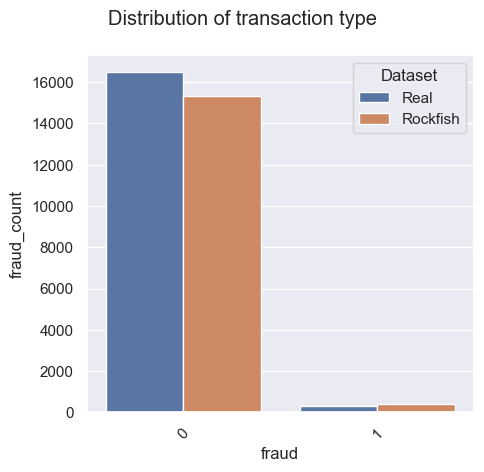

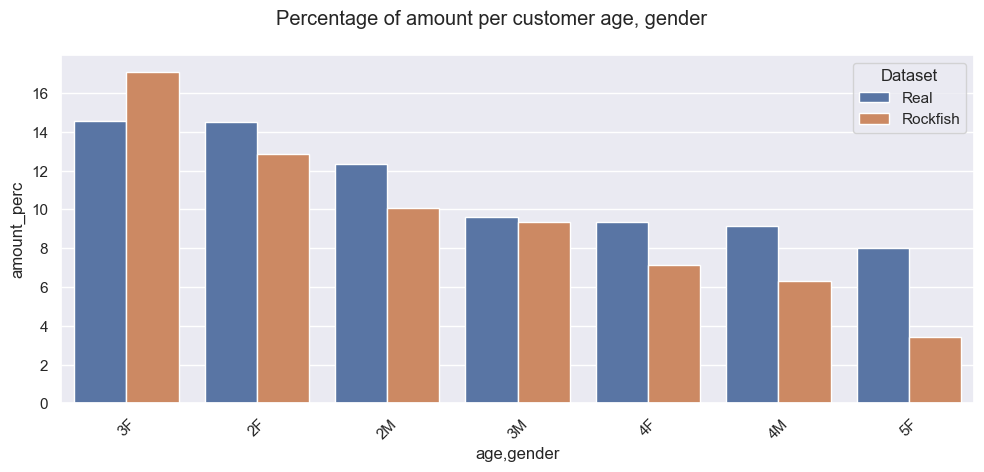

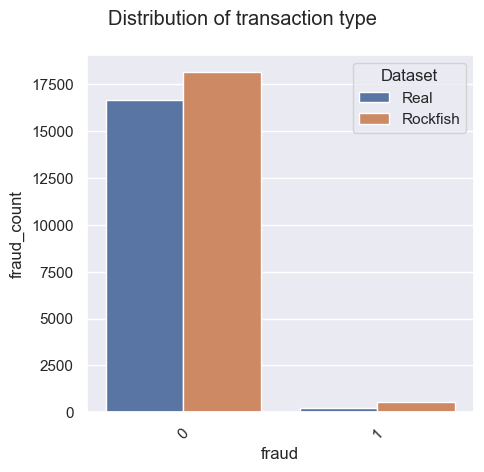

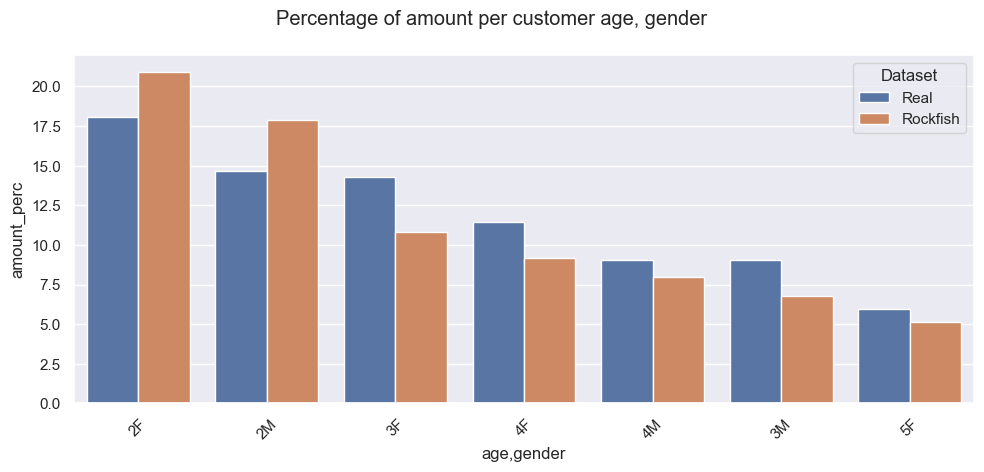

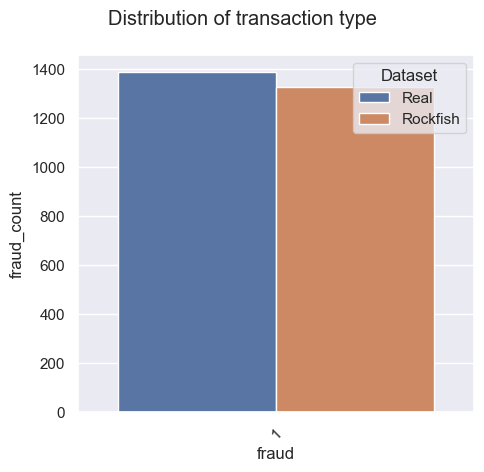

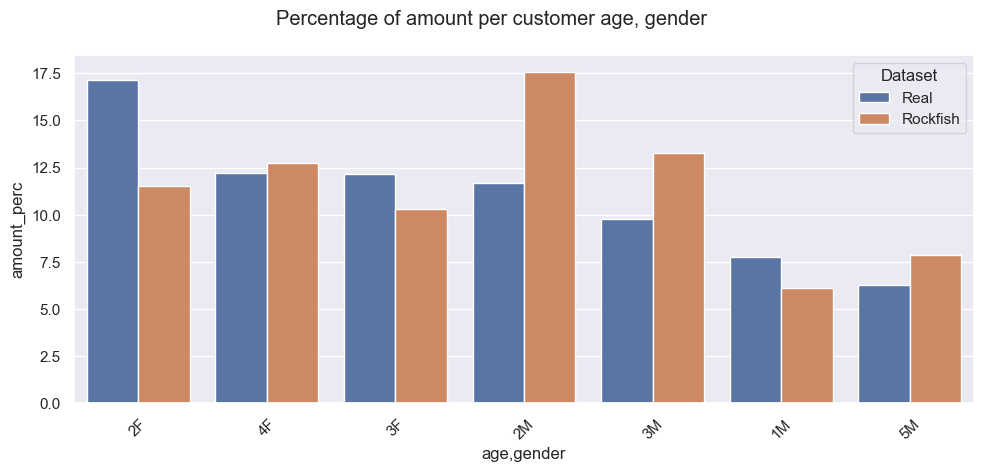

In [19]:
for name in dataset_names:
    print(f"Running data quality check on table: {name}")
    real_data = rf.Dataset.from_csv(name="Real", path=f"{name}.csv")
    syn_data = rf.Dataset.from_csv(name="Rockfish", path=f"{name}_syn.csv")
    data_quality_check(real_data, syn_data, fidelity_requirements)

## Generate

In [37]:
# source 1
model = await conn.list_models(
    labels={"kind": "model_transactions_2023-08-01_hour09", "workflow_id": runtime_workflow.id()}
).last()
session_target = ra.SessionTarget(target=10000, max_cycles=1000)
alter_timestamp = ra.AlterTimestamp(field="timestamp", 
                                    start_time=datetime(2024, 8, 8, 9, 0, 0, 0, pytz.UTC), 
                                    end_time=datetime(2024, 8, 8, 18, 0, 0, 0, pytz.UTC), 
                                    flow_start_type="random", 
                                    interarrival_type="original")
save = ra.DatasetSave(name="synthetic", concat_tables=True, concat_session_key="session_key")

In [38]:
builder = rf.WorkflowBuilder()
builder.add(model)
builder.add(generate_action, parents=[model, session_target])
builder.add(session_target, parents=[generate_action])
builder.add(alter_timestamp, parents=[generate_action])
builder.add(save, parents=[alter_timestamp])
source1_workflow = await builder.start(conn)
source1_workflow.id()

'4Eh4sSvckO3NxzuOqP3v34'

In [39]:
source1_syn = await (await source1_workflow.datasets().last()).to_local(conn)

In [40]:
# source 2
model = await conn.list_models(
    labels={"kind": "model_transactions_2023-08-01_hour11", "workflow_id": runtime_workflow.id()}
).last()
session_target = ra.SessionTarget(target=1500, max_cycles=1000)
post_amplify = ra.PostAmplify({
                    "query_ast": {
                        "and": [{"eq": ["fraud", 1]}, {"eq": ["category", "transportation"]}],
                    },
                    "drop_match_percentage": 0.0,
                    "drop_other_percentage": 0.95,
                })
alter_timestamp = ra.AlterTimestamp(field="timestamp", 
                                    start_time=datetime(2024, 8, 8, 12, 30, 0, 0, pytz.UTC), 
                                    end_time=datetime(2024, 8, 8, 16, 30, 0, 0, pytz.UTC), 
                                    flow_start_type="random", 
                                    interarrival_type="original")
save = ra.DatasetSave(name="synthetic", concat_tables=True, concat_session_key="session_key")

In [41]:
builder = rf.WorkflowBuilder()
builder.add(model)
builder.add(generate_action, parents=[model, session_target])
builder.add(post_amplify, parents=[generate_action])
builder.add(session_target, parents=[post_amplify])
builder.add(alter_timestamp, parents=[post_amplify])
builder.add(save, parents=[alter_timestamp])
source2_workflow = await builder.start(conn)
source2_workflow.id()

'6k8xj588BrbBDKIEzGKLf7'

In [42]:
source2_syn = await (await source2_workflow.datasets().last()).to_local(conn)

In [43]:
builder = rf.WorkflowBuilder()
builder.add(source1_syn)
builder.add(source2_syn)
builder.add(ra.DatasetSave(name="story", concat_tables=True, concat_session_key="session_key"), parents=[source1_syn, source2_syn])
story_workflow = await builder.start(conn)
story_workflow.id()

'3YnrFzYsLBL5GpoQ3veDBo'

In [44]:
story_syn = await (await story_workflow.datasets().last()).to_local(conn)

<Axes: xlabel='ts_min'>

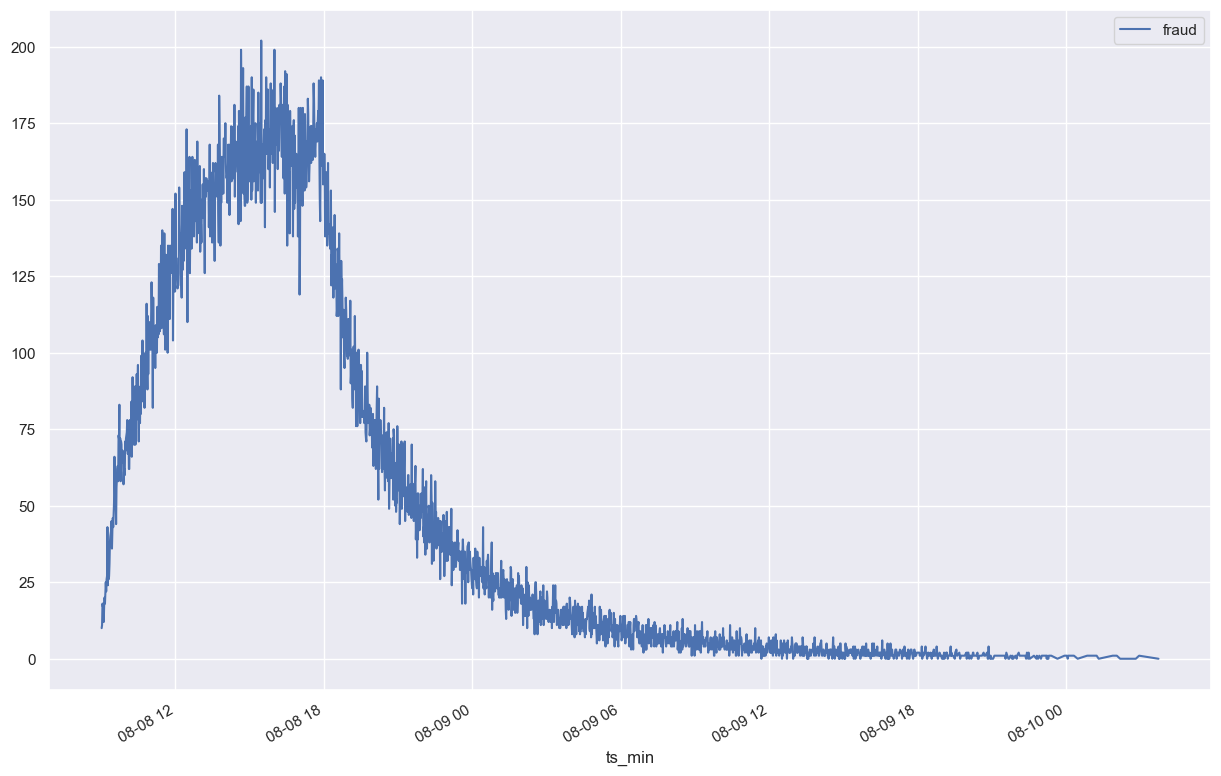

In [51]:
df = story_syn.to_pandas()
df["ts_min"] = df["timestamp"].dt.ceil('min')
df.groupby("ts_min")[["fraud"]].agg("sum").plot(figsize=(15, 10))